In [2]:
!pip install mcap-ros2-support mcap

In [3]:
import math

In [4]:
from mcap_ros2.decoder import DecoderFactory
from mcap.reader import make_reader

magnetometer_data = []
printer_data = []
with open(
    "../data/rosbag2_2024_01_11-11_38_41/rosbag2_2024_01_11-11_38_41_0.mcap",
    "rb",
) as fd:
    reader = make_reader(fd, decoder_factories=[DecoderFactory()])
    for schema, channel, message, ros_msg in reader.iter_decoded_messages(
    ):
        # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
        if channel.topic == "/magnetometer_reading":
            for reading in ros_msg.magnetic_field_array:
                timestamp = reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                magnetic_field_x = reading.magnetic_field.x
                magnetic_field_y = reading.magnetic_field.y
                magnetic_field_z = reading.magnetic_field.z
                magnetometer_data.append([timestamp, magnetic_field_x, magnetic_field_y, magnetic_field_z])

        elif channel.topic == "/tf":
            for transform in ros_msg.transforms:
                if transform.header.frame_id == "printer_head_link":
                    timestamp = transform.header.stamp.sec + transform.header.stamp.nanosec * 1e-9
                    x = transform.transform.translation.x
                    y = transform.transform.translation.y
                    z = transform.transform.translation.z
                    printer_data.append([timestamp, x, y, z])

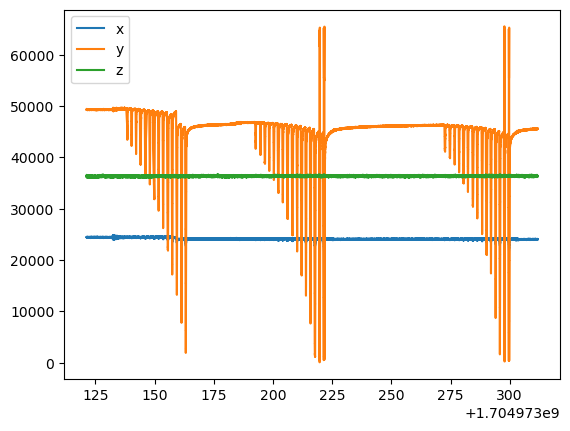

In [5]:
from matplotlib import pyplot as plt

plt.plot([x[0] for x in magnetometer_data], [x[1] for x in magnetometer_data], label="x")
plt.plot([x[0] for x in magnetometer_data], [x[2] for x in magnetometer_data], label="y")
plt.plot([x[0] for x in magnetometer_data], [x[3] for x in magnetometer_data], label="z")
plt.legend()
plt.show()

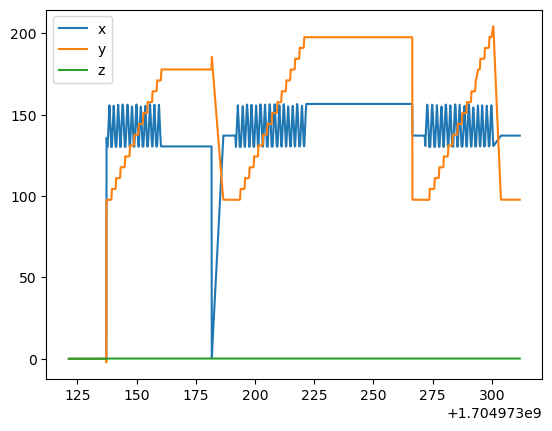

In [6]:
plt.plot([x[0] for x in printer_data], [x[1] for x in printer_data], label="x")
plt.plot([x[0] for x in printer_data], [x[2] for x in printer_data], label="y")
plt.plot([x[0] for x in printer_data], [x[3] for x in printer_data], label="z")
plt.legend()
plt.show()

In [7]:
import numpy as np
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 850       # sample rate, Hz
cutoff = 2     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
# n = len(y_data) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # print(b.dtype, a.dtype)
    y = filtfilt(b, a, data)
    return y

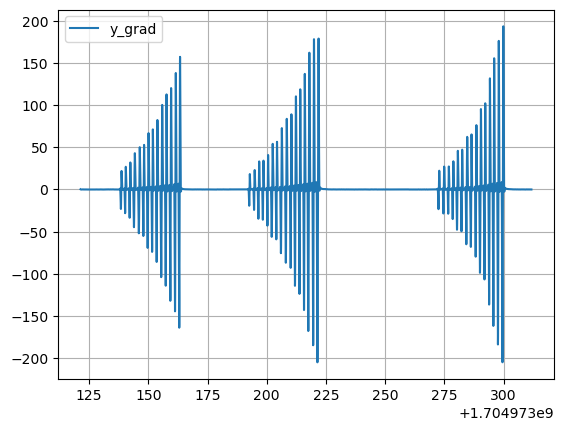

In [8]:
# get gradient of sensor data
import numpy as np

y_data = [float(x[2]) for x in magnetometer_data]
for i in range(len(y_data)):
    if y_data[i] > 55000:
        y_data[i] = y_data[i] - 2**16
y_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)
y_grad = np.gradient(y_filtered)

plt.plot([x[0] for x in magnetometer_data], y_grad, label="y_grad")
plt.legend()
plt.grid()
plt.show()

In [9]:
episodes = []
open_episode = True
episode_start = 0

t_data = [x[0] for x in magnetometer_data]

print(len(y_grad), len(t_data))
for idx, pt in enumerate(y_grad):
    if open_episode:
        if pt < -10:
            # found start of episode
            open_episode = False
            episode_start = t_data[idx]
        else:
            continue
    else:
        if pt > 10:
            # found end of episode
            open_episode = True
            episodes.append((episode_start, t_data[idx]))
        else:
            continue

169063 169063


45
[5.894999999999996, 12.569999999999993, 19.239999999999995, 25.894999999999996, 32.56, 39.25, 45.89999999999999, 52.59500000000001, 59.24499999999999, 65.90499999999999, 72.575, 79.25500000000001, 86.06, 86.06, 5.885000000000005, 12.560000000000002, 19.22, 25.89, 32.56, 39.21499999999999, 45.89999999999999, 52.56, 59.239999999999995, 65.925, 72.57, 79.25, 85.90499999999999, 92.58000000000001, 99.25, 105.91, 5.880000000000003, 12.545000000000002, 19.224999999999994, 25.894999999999996, 32.555, 39.230000000000004, 45.889999999999986, 52.575, 59.239999999999995, 65.895, 72.575, 83.645, 92.585, 99.25, 105.91999999999999]
[-23.11946391671154, -28.16764821689867, -33.59154098519866, -44.77838601433905, -52.0248860390202, -55.22117131634877, -69.3679940919501, -74.10789889088119, -86.0555132638001, -104.13708907711771, -114.27234984318056, -132.20626530675872, -144.7041407488814, -164.1431724734739, -19.30347881216221, -24.268757152916805, -34.72712862047047, -35.924465005886304, -42.94832

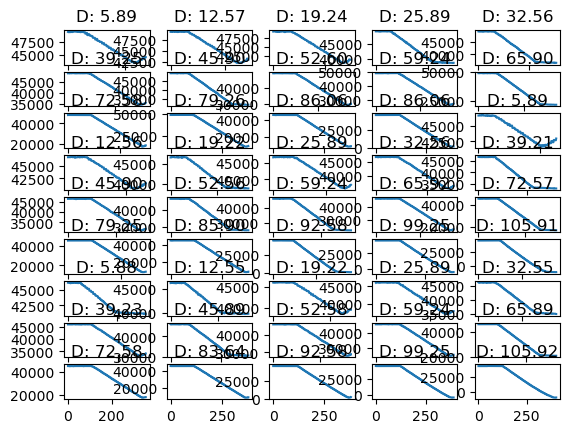

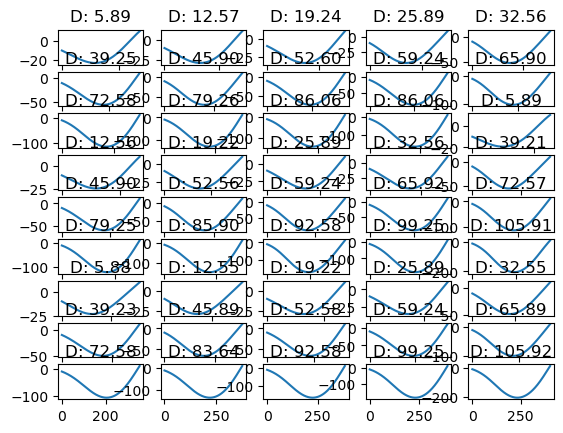

In [10]:
shaft_timestamp = [x[0] for x in printer_data]

BEAM_EDGE_Y_RELATIVE_TO_NOZZLE = 56.75
WHISKER_TIP_Y = 35  # from the base of the printer bed


def distance_on_shaft(y):
    return y - BEAM_EDGE_Y_RELATIVE_TO_NOZZLE - WHISKER_TIP_Y


shaft_data = [distance_on_shaft(x[2]) for x in printer_data]


shaft_data_zipped = list(zip(shaft_timestamp, shaft_data))
shaft_data_per_episode = []

episodes_data = []
episodes_grad_data = []
for episode_start, episode_end in episodes:
    episodes_data.append(
        [y for t, y in zip(t_data, y_data) if t >= episode_start and t <= episode_end]
    )
    shaft_data_per_episode.append(
        [
            x[1]
            for x in shaft_data_zipped
            if x[0] >= episode_start and x[0] <= episode_end
        ]
    )
    episodes_grad_data.append(
        [y for t, y in zip(t_data, y_grad) if t >= episode_start and t <= episode_end]
    )

shaft_distance_per_episode = [float(np.median(x)) for x in shaft_data_per_episode]

print(len(episodes_data))
fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
for idx, data in enumerate(episodes_data):
    ax = axes[idx // 5, idx % 5]
    ax.plot(data)
    ax.title.set_text(f"D: {shaft_distance_per_episode[idx]:.2f}")


fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
for idx, data in enumerate(episodes_grad_data):
    ax = axes[idx // 5, idx % 5]
    ax.plot(data)
    ax.title.set_text(f"D: {shaft_distance_per_episode[idx]:.2f}")


max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
print(shaft_distance_per_episode)
print(max_grad_per_episode)

45 45


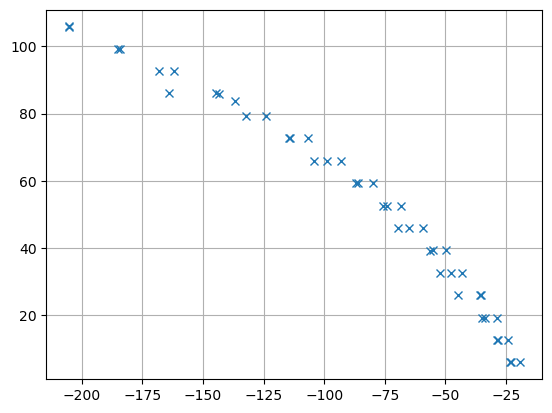

In [11]:
print(len(shaft_distance_per_episode), len(max_grad_per_episode))

plt.plot([x for x in max_grad_per_episode], shaft_distance_per_episode, "x")
plt.grid()

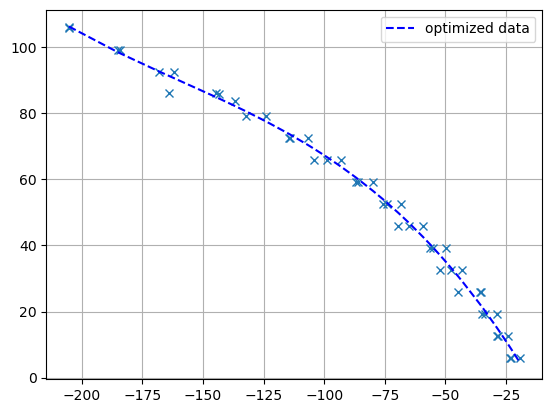

In [12]:
# curve-fit() function imported from scipy
from scipy.optimize import curve_fit

def whisker_model(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d
 
param, param_cov = curve_fit(whisker_model, max_grad_per_episode, shaft_distance_per_episode)
 
plt.plot([x for x in max_grad_per_episode], shaft_distance_per_episode, "x")
plt.grid()

ans = [whisker_model(x, param[0], param[1], param[2], param[3]) for x in sorted(max_grad_per_episode)]

plt.plot(sorted(max_grad_per_episode), ans, '--', color ='blue', label ="optimized data")
plt.legend()
plt.show()

In [13]:
import pickle

with open("whisker_model.pkl", "wb") as fd:
    pickle.dump(param, fd)

In [14]:
with open("whisker_model.pkl", "rb") as fd:
    print(pickle.load(fd))

[-1.42945556e-05 -6.82835370e-03 -1.41567742e+00 -2.02926956e+01]


In [15]:
for idx, data in enumerate(episodes_data):
    print(len(data))

275
287
299
376
386
329
392
347
355
428
373
382
381
388
253
268
338
293
304
401
325
395
406
352
423
369
378
452
394
445
318
329
276
290
362
311
384
331
342
414
357
379
385
392
404
